# Satellite attitude control using reinforcement learning

The following section solves the probem using a simple Quaternion Rate Feedback (QRF) controller for one set of inertia and mass.


In [1]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import animation, rc

from IPython.display import HTML
%matplotlib inline

In [2]:
import sat_mujocoenv
import PPO_par as ppo


In [3]:
#Parameters
horizon = 1500 #steps
maxabs_torque=1.0e-2
dt = 10
target_state = np.array([1,0,0,0,0,0,0]) # [q_0,q_1,q_2,q_3,w_0,w_1,w_2]
w_mag = 4e-2
w_tumble = 1
Noise = None
render = False

In [4]:
env = sat_mujocoenv.Sat_mujocoEnv(horizon,maxabs_torque,dt,target_state, w_mag ,w_tumble, Noise,render)

In [5]:
T = horizon
env.reset()
s = np.zeros((T, env.observation_dim))
r = np.zeros(T)
a = np.zeros((T, env.action_dim))
a_actual = np.zeros((T, env.action_dim))
time = np.zeros(T)
s[0,:] = env.x
for t in range(1,T):
    a[t] =-10e-2*(s[t-1,1:4]-target_state[1:4])-10*(s[t-1,4:]--target_state[4:])
    s[t,:], r[t], _ = env.step(a[t])
    a_actual[t] = env.a
    time[t] = env.t

average reward per step = 0.36966912453286804


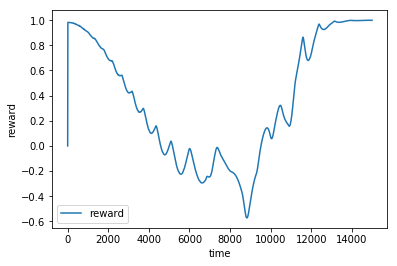

In [6]:
plt.plot(time,r, label='reward')
plt.xlabel('time')
plt.ylabel('reward')
plt.legend()
print(f'average reward per step = {np.mean(r)}')

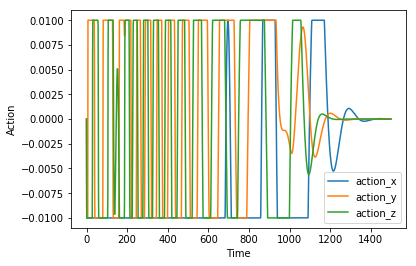

In [7]:
plt.plot(a_actual)
plt.ylabel('Action')
plt.xlabel('Time')
plt.legend(('action_x', 'action_y', 'action_z'))

No handles with labels found to put in legend.


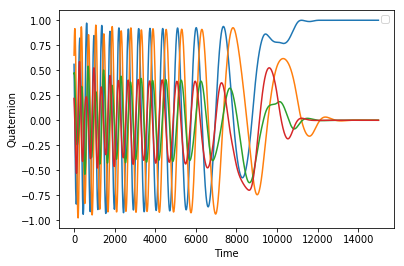

In [8]:
plt.ylabel('Quaternion')
plt.xlabel('Time')
plt.legend()
plt.plot(time,s[:,0:4], label='x')

No handles with labels found to put in legend.


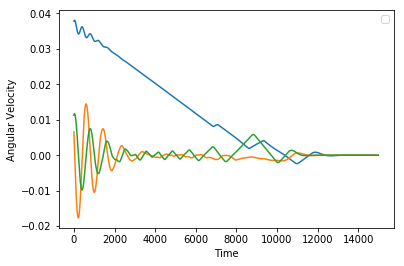

In [9]:
plt.ylabel('Angular Velocity')
plt.xlabel('Time')
plt.legend()
plt.plot(time,s[:,4:], label='x')

# PPO training

In [10]:
env = sat_mujocoenv.Sat_mujocoEnv(horizon,maxabs_torque,dt,target_state, w_mag ,w_tumble, Noise,render)
agent = ppo.PPOAgent(env)

In [11]:
gamma = 0.99
lamb = 0.99
number_of_actors = 25
number_of_iterations = 500
number_of_epochs = 100
minibatch_size = 500
logstd_initial = -1 #-0.7
logstd_final = -2 # -1.6
epsilon = 0.1
use_multiprocess = False
res = agent.train(
    'Sat',
    gamma,
    lamb,
    number_of_actors,
    number_of_iterations,
    horizon,
    number_of_epochs,
    minibatch_size,
    logstd_initial,
    logstd_final,
    epsilon,
    use_multiprocess,
)

percent done:  0.0
percent done:  10.0
percent done:  20.0
percent done:  30.0
percent done:  40.0
percent done:  50.0
percent done:  60.0
percent done:  70.0
percent done:  80.0
percent done:  90.0


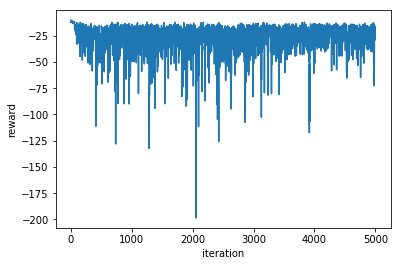

In [12]:
plt.plot(res['rewards'])
plt.xlabel('iteration')
plt.ylabel('reward');
#plt.xlim([1,-1000])

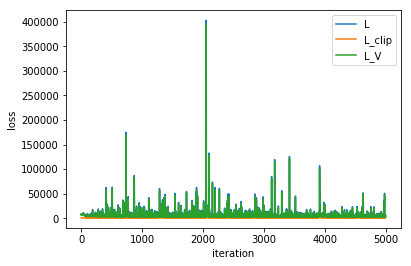

In [13]:
plt.plot(res['losses'], label='L')
plt.plot(res['losses_clip'], label='L_clip')
plt.plot(res['losses_V'], label='L_V')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend();

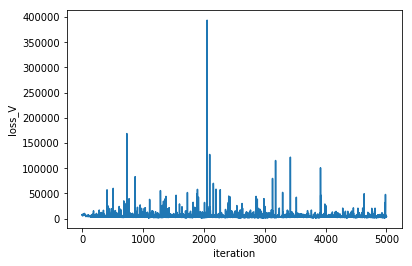

In [14]:
plt.plot(res['losses_V'], label='L_V')
plt.xlabel('iteration')
plt.ylabel('loss_V');

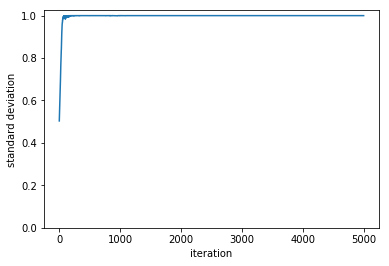

In [15]:
plt.plot(res['stds'])
plt.xlabel('iteration')
plt.gca().set_ylim(bottom=0)
plt.ylabel('standard deviation');

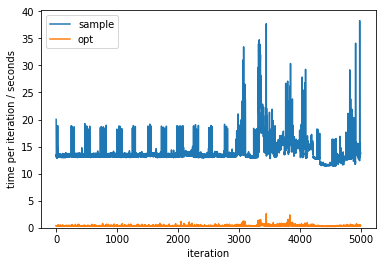

In [16]:
plt.plot(res['times_sample'], label='sample')
plt.plot(res['times_opt'], label='opt')
plt.gca().set_ylim(bottom=0)
plt.legend();
plt.xlabel('iteration')
plt.ylabel('time per iteration / seconds');

# Satellite simulation with agent

In [36]:
env = sat_mujocoenv.Sat_mujocoEnv(horizon,maxabs_torque,dt,target_state, w_mag ,w_tumble, Noise,render)

In [47]:
T = horizon
env.reset()
s = np.zeros((T, env.observation_dim))
r = np.zeros(T)
a = np.zeros((T, env.action_dim))
time = np.zeros(T)
s[0,:] = env.x
for t in range(1,T):
    a[t] = agent.action_greedy(s[t-1,:])
    s[t,:], r[t], _ = env.step(a[t])
    a_actual[t] = env.a
    time[t] = (t - 1) * env.dt

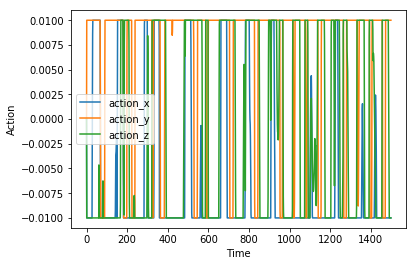

In [48]:
plt.plot(a_actual)
plt.ylabel('Action')
plt.xlabel('Time')
plt.legend(('action_x', 'action_y', 'action_z'))

average reward per step = -2.729638438402462


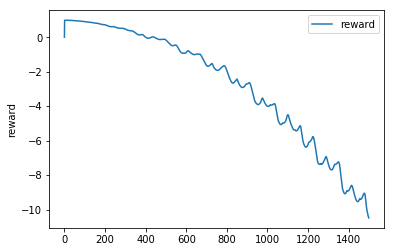

In [49]:
plt.plot(r, label='reward')
plt.ylabel('reward')
plt.legend()
print(f'average reward per step = {np.mean(r)}')

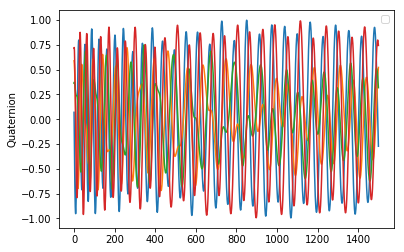

In [50]:
plt.ylabel('Quaternion')
plt.legend()
plt.plot(s[:,0:4], label='x')

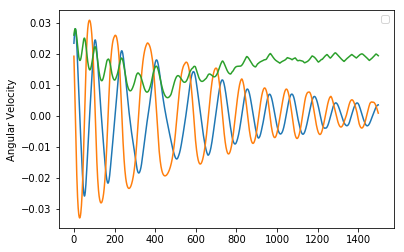

In [51]:
plt.ylabel('Angular Velocity')
plt.legend()
plt.plot(s[:,4:], label='x')

In [35]:
for p in agent.net.parameters():
    print(p)

Parameter containing:
tensor([[ -0.0342,  -0.0123,  -0.0098,  -0.0223,   0.4132,  -0.4126,   1.9473],
        [ -0.0243,   0.0018,   0.0355,   0.0428,   4.5712,  -2.7912,   6.7362],
        [  0.0129,  -0.0281,  -0.0146,  -0.0075,  -0.1234,  -2.9686,  -4.9051],
        [  0.2285,  -0.3477,  -0.0270,  -0.1163,   1.2701,  -0.3306,   0.2202],
        [  0.1019,  -0.0226,  -0.0105,  -0.0545,   1.0102,  -1.3910,   2.4988],
        [  0.1208,  -0.0242,   0.1430,  -0.4880,   1.3233,   0.6046,  -0.9871],
        [ -0.1085,  -0.1309,   0.0490,  -0.2008,  -1.0200,   1.2507,   2.1367],
        [ -0.1103,  -0.2147,  -0.0804,  -0.7767,  -0.5302,   4.2999,   0.1850],
        [  0.0359,   0.0585,  -0.0059,  -0.0555,   7.8123,  -3.6240,  -1.0600],
        [  0.0194,   0.0758,  -0.0193,  -0.0073,   0.8116,  -0.6936,   3.9162],
        [  0.1733,  -0.0934,  -0.0488,  -0.0503,  -0.3904,   0.3518,  -0.6996],
        [  0.1318,  -0.0361,  -0.1202,   0.1101,   2.7174,   0.6004,   6.6460],
        [ -0.0343,